<a href="https://colab.research.google.com/github/mobinym/Space_TItanic_Kaggle/blob/main/kaggle_V2.0.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading

clear_output()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv("/content/drive/MyDrive/DataSets/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DataSets/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/DataSets/sample_submission.csv")

RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [11]:
print(f'Number of rows in train data: {train.shape[0]}')
print(f'Number of columns in train data: {train.shape[1]}')
print(f'Number of values in train data: {train.count().sum()}')
print(f'Number missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


### <span style="color:#e76f51;"> Column Wise missing values : </span>

In [12]:
print(train.isna().sum().sort_values(ascending = False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [37]:
train.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.00,8693.00,8693.00,8693.00,8693.00,8693.00,8693.00,8693.00,8693.00,8693.00
mean,0.72,0.40,1.52,28.79,0.07,220.01,448.43,169.57,304.59,298.26
std,0.86,0.54,0.84,14.34,0.33,660.52,1595.79,598.01,1125.56,1134.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,2.00,27.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,2.00,37.00,0.00,41.00,61.00,22.00,53.00,40.00
max,3.00,2.00,3.00,79.00,2.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [ ]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [14]:
print(f'Number of rows in test data: {test.shape[0]}')
print(f'Number of columns in test data: {test.shape[1]}')
print(f'Number of values in train data: {test.count().sum()}')
print(f'No of rows with missing values  in test data: {sum(test.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
No of rows with missing values  in test data: 1117


### <span style="color:#e76f51;"> Column Wise missing values </span>

In [15]:
print((test.isna().sum().sort_values(ascending = False)))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [16]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


In [17]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [18]:
train.drop(["PassengerId"] , axis = 1 , inplace = True)
test.drop(["PassengerId"] , axis = 1 , inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [19]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


In [20]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]


fig = make_subplots(rows=1,
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)],
                                line_color='rgb(0,0,0)' ,
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0],
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)],
                                line_color='rgb(0,0,0)',
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

<a id="4.7.2"></a>
### <span style="color:#e76f51;">Row wise Null Value Distribution   </span>

In [21]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1,
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"],
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)],
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"],
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)],
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

In [22]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors,
                line=dict(color='#000000',
                          width=2))
)])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


In [23]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf,
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

In [24]:
if len(cat_features) == 0 :
    print("no category feature")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[r,c] ,palette = "magma", label='Test data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

KeyboardInterrupt: 

In [25]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df,
             x = TARGET,
             y = 'count'
            )
fig.update_traces(marker_color =['#58D68D','#DE3163'],
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


In [26]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy=STRATEGY )
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

### <span style="color:#e76f51;">Encoding Categorical Features </span>

In [27]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(train,test ,label_cols)

In [28]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X ,
                                                       y,
                                                       random_state = 12 ,
                                                       test_size =0.33)

In [29]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)
clear_output()

### <span style="color:#e76f51;">TOP 15 Models </span>

In [30]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.79,0.79,0.79,0.23
XGBClassifier,0.78,0.78,0.78,0.78,0.24
RandomForestClassifier,0.77,0.77,0.77,0.77,0.92
NuSVC,0.77,0.77,0.77,0.77,2.26
LogisticRegression,0.77,0.77,0.77,0.77,0.04
SVC,0.77,0.77,0.77,0.77,1.69
ExtraTreesClassifier,0.76,0.76,0.76,0.76,0.86
LinearSVC,0.76,0.76,0.76,0.76,0.04
BaggingClassifier,0.76,0.76,0.76,0.76,0.24


### <span style="color:#e76f51;">Visualizing Results </span>

In [ ]:
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [ ]:
line = px.line(data_frame= models ,y =["ROC AUC" , "F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "ROC AUC SCORE")
line.update_layout(showlegend = True,
    title = {
        'text': 'ROC AUC and F1 Score vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [ ]:
line = px.line(data_frame= models ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'TIME TAKEN vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

<a id="6.2"></a>
## <span style="color:#e76f51;"> LGBM Classifier(5 FOLDS)  : </span>

In [31]:
lgb_params = {
    'objective' : 'binary',
    'n_estimators' :50,
    'learning_rate' : 0.08
}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):

    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()

    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]

    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)

    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time

    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)

    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES])
    lgb_predictions += test_preds/FOLDS
print("")
print("Mean Accuracy :", np.mean(lgb_scores))

========== Fold=1 ==========
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
Fold=1, Accuracy score: 0.81%, Run Time: 0.12s
========== Fold=2 ==========
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [I

### <span style="color:#e76f51;">Feature Importance </span>

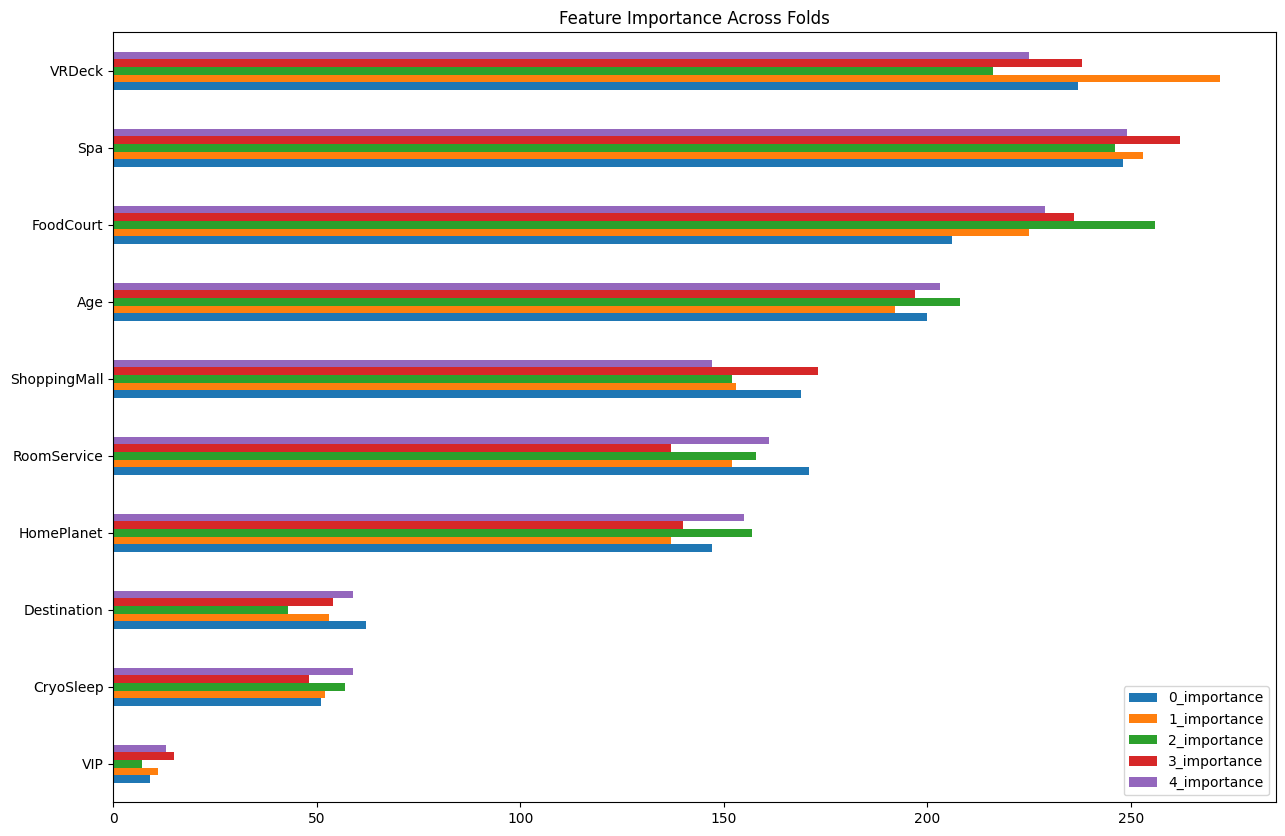

In [33]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()


### <span style="color:#e76f51;">LGBM Classifier Submission : </span>

In [ ]:
submission[TARGET] = lgb_predictions.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
